In [12]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [25]:
if torch.cuda.is_available(): 
 dev = "cuda:0" 
else: 
 dev = "cpu" 
device = torch.device(dev) 
print(f'Using {device}')

Using cuda:0


In [275]:
class ConvLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, conv_channels, conv_kernel_sizes):
        super(ConvLSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.softmax = nn.Softmax()
        
        # # Define 1D convolutional layers
        # self.conv_layers = nn.ModuleList()
        # for i, (out_channels, kernel_size) in enumerate(zip(conv_channels, conv_kernel_sizes)):
        #     if i == 0:
        #         self.conv_layers.append(nn.Conv1d(input_size, out_channels, kernel_size, bias=False))
        #     else:
        #         self.conv_layers.append(nn.Conv1d(conv_channels[i-1], out_channels, kernel_size, bias=False))
        
        # Define LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
        # Define fully connected layer
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        # Apply 1D convolutional layers
        # for conv_layer in self.conv_layers:
        #     x = conv_layer(x)
        #     x = nn.functional.relu(x)
        
        # Permute tensor to match LSTM input shape
        x = x.permute(0, 2, 1)
        
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])

        # Apply Softmax Function to get vector of probabilities
        out = self.softmax(out)
        return out

In [235]:
def create_dataset(dataset, output_categories, length):
    X, y = [], []
    for i in range(len(dataset) - length):
        feature = dataset[i:i+length]
        target = np.where(output_categories == dataset[i+1:i+length+1])[1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.eye(len(output_categories))[y]

def normalize_data(data):
    min_val = torch.min(data)
    max_val = torch.max(data)
    normalized_data = (data - min_val) / (max_val - min_val)
    return normalized_data

def midi_to_note_name(midi_note):
    """
    Convert MIDI note number to note name.
    """
    notes = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    octave = (midi_note // 12) - 1
    note_index = midi_note % 12
    note_name = notes[note_index]
    return f"{note_name}{octave}"

def plotMusic(data, figure):
    plt.figure(figure.number)  # Activate the provided figure
    x = data['start_beat']
    y = data['note']
    
    for i in range(len(x)):
        plt.plot([x[i], x[i] + data['end_beat'][i]], [y[i], y[i]], 'blue')

    for i in range(1, int(x.max() / 4) + 1):
        plt.axvline(x=i * 4, color='r', linestyle='--')

    plt.title(f"{metadata['composition'].loc[metadata['id'] == musicId]}")
    plt.xlabel("Beats - Line at every measure")
    plt.ylabel("Note")
    plt.yticks(y, [midi_to_note_name(i) for i in y])
    plt.grid(True)
    plt.show()


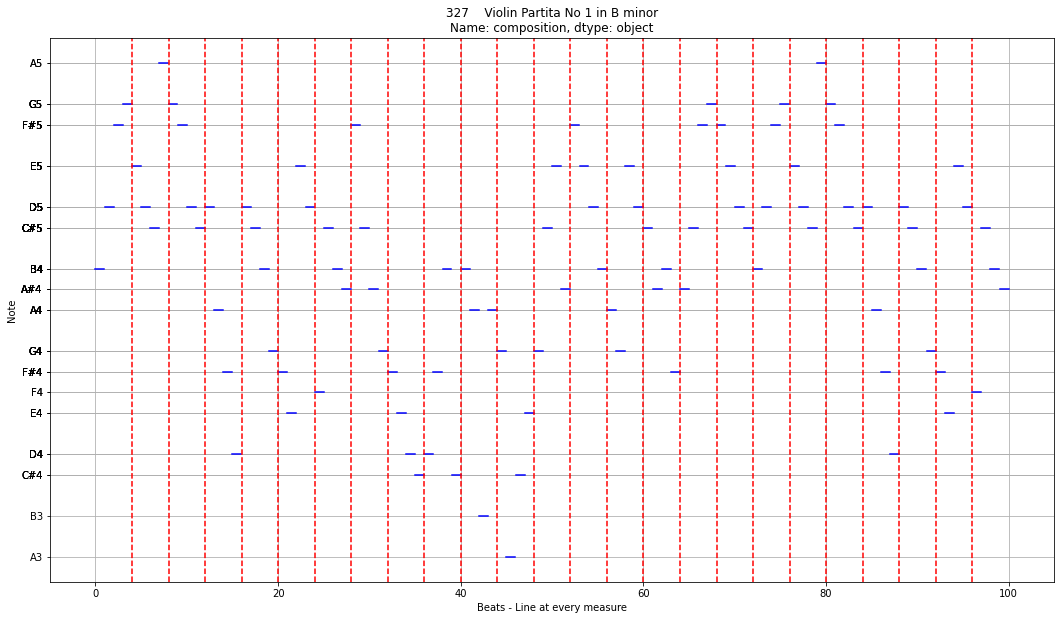

In [302]:
# Input Metadata into Pandas
dataDir = "../music_data/"
metadata = pd.read_csv(os.path.join(dataDir, "musicnet_metadata.csv"))

# Load Dataset
musicId = 2659 
if musicId not in metadata['id'].values:
    musicId = metadata['id'].sample().iloc[0]
    
df = pd.read_csv(f'musicnet/train_labels/{musicId}.csv')
plotMusic(df[:100], plt.figure(figsize=(18, 10)))

In [138]:
output_categories = df['note'].unique()
for note in np.sort(output_categories):
    print(f"Note: {note} = {midi_to_note_name(note)}, ")
print(f"Total Number of Unique Notes: {len(output_categories)}")

Note: 55 = G3, 
Note: 57 = A3, 
Note: 59 = B3, 
Note: 61 = C#4, 
Note: 62 = D4, 
Note: 63 = D#4, 
Note: 64 = E4, 
Note: 65 = F4, 
Note: 66 = F#4, 
Note: 67 = G4, 
Note: 68 = G#4, 
Note: 69 = A4, 
Note: 70 = A#4, 
Note: 71 = B4, 
Note: 72 = C5, 
Note: 73 = C#5, 
Note: 74 = D5, 
Note: 75 = D#5, 
Note: 76 = E5, 
Note: 77 = F5, 
Note: 78 = F#5, 
Note: 79 = G5, 
Note: 80 = G#5, 
Note: 81 = A5, 
Note: 82 = A#5, 
Note: 83 = B5, 
Note: 84 = C6, 
Note: 85 = C#6, 
Total Number of Unique Notes: 28


In [220]:
output_categories

array([71, 74, 78, 79, 76, 73, 81, 69, 66, 62, 67, 64, 65, 70, 61, 59, 57,
       82, 83, 80, 68, 75, 84, 72, 63, 55, 85, 77], dtype=int64)

In [236]:
# Create Dataset
note_timeseries = np.zeros((df['start_beat'].size, 1))
for i in range(df['start_beat'].size):
    note_timeseries[i:i + int(np.ceil(df['end_beat'][i])), :] = int(df['note'][i])

train_size = int(np.floor(len(note_timeseries) * .7))
test_size = len(note_timeseries) - train_size
train, test = np.array(note_timeseries[:train_size]), np.array(note_timeseries[train_size:])

X_train, y_train = create_dataset(train, output_categories, length = 7)
X_test, y_test = create_dataset(test, output_categories, length = 7)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([391, 7, 1]) torch.Size([391, 7, 28])
torch.Size([164, 7, 1]) torch.Size([164, 7, 28])


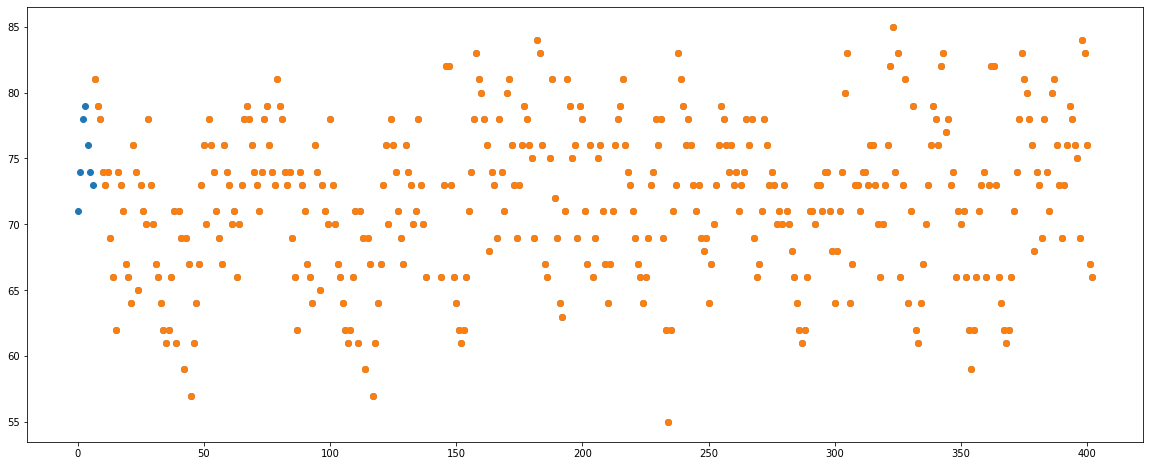

In [247]:
plt.figure(figsize=(20, 8))
plt.scatter(df['start_beat'][:train_size], train)
plt.scatter(df['start_beat'][7:train_size], output_categories[np.argmax(y_train[:, -1, :], axis=1)])


In [248]:
X_train = normalize_data(X_train.to(torch.float32))
y_train = y_train.to(torch.float32)
X_test = normalize_data(X_test.to(torch.float32))
y_test = y_test.to(torch.float32)

In [300]:
import torch.optim as optim
import torch.utils.data as data

model = ConvLSTMModel(input_size = 7, hidden_size = 100, num_layers = 3, output_size = len(output_categories), conv_channels = [16, 32], conv_kernel_sizes = [1, 1])
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=False, batch_size=8)
 
n_epochs = 10000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch[:, -1, :])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train[:, -1, :]))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test[:, -1, :]))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 1.8184, test RMSE 1.8180
Epoch 100: train RMSE 1.7844, test RMSE 1.7805
Epoch 200: train RMSE 1.7802, test RMSE 1.7772
Epoch 300: train RMSE 1.8051, test RMSE 1.8000
Epoch 400: train RMSE 1.7779, test RMSE 1.7825
Epoch 500: train RMSE 1.7691, test RMSE 1.7750
Epoch 600: train RMSE 1.7726, test RMSE 1.7774
Epoch 700: train RMSE 1.7614, test RMSE 1.7681
Epoch 800: train RMSE 1.7446, test RMSE 1.7603
Epoch 900: train RMSE 1.7397, test RMSE 1.7601
Epoch 1000: train RMSE 1.7276, test RMSE 1.7468
Epoch 1100: train RMSE 1.7233, test RMSE 1.7438
Epoch 1200: train RMSE 1.7182, test RMSE 1.7364
Epoch 1300: train RMSE 1.7192, test RMSE 1.7383
Epoch 1400: train RMSE 1.7076, test RMSE 1.7216
Epoch 1500: train RMSE 1.6959, test RMSE 1.7068
Epoch 1600: train RMSE 1.6834, test RMSE 1.7041
Epoch 1700: train RMSE 1.6808, test RMSE 1.7008
Epoch 1800: train RMSE 1.6759, test RMSE 1.6946
Epoch 1900: train RMSE 1.6729, test RMSE 1.6920
Epoch 2000: train RMSE 1.6697, test RMSE 1.6895
Epoc

c:\users\kanis\appdata\local\programs\python\python39\lib\site-packages\torch\nn\modules\module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


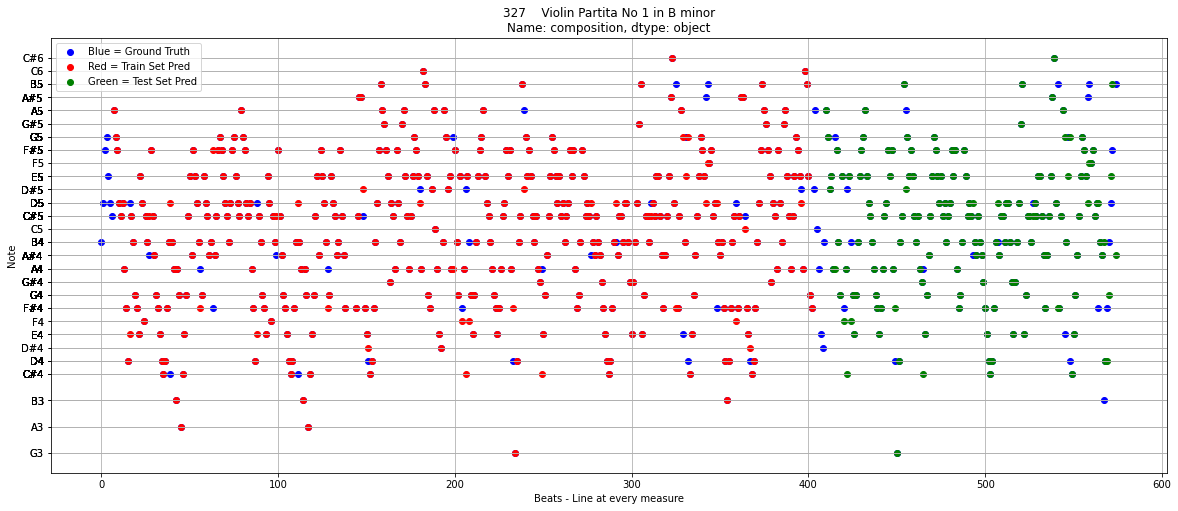

In [326]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(note_timeseries) * np.nan
    y_pred = model(X_train)
    train_plot[7:train_size] = output_categories[np.argmax(y_pred, axis=1)][:, np.newaxis]
    
    # shift test predictions for plotting
    test_plot = np.ones_like(note_timeseries) * np.nan
    test_plot[train_size+7:len(note_timeseries)] = output_categories[np.argmax(model(X_test), axis=1)][:, np.newaxis]
# plot
plt.figure(figsize=(20, 8))
plt.scatter(df['start_beat'], note_timeseries, c='b')
plt.scatter(df['start_beat'], train_plot, c='r')
plt.scatter(df['start_beat'], test_plot, c='g')
plt.title(f"{metadata['composition'].loc[metadata['id'] == musicId]}")
plt.xlabel("Beats - Line at every measure")
plt.ylabel("Note")
plt.yticks(df['note'], [midi_to_note_name(i) for i in df['note']])
plt.legend(["Blue = Ground Truth", "Red = Train Set Pred", "Green = Test Set Pred"])
plt.grid(True)
plt.show()

torch.Size([391, 7, 1])

In [304]:
model100_3 = model

In [305]:
models = {"128h,3layer" : model128_3, "100h,3layer" : model100_3}

In [320]:
for key in models.keys():
    torch.save(models[key], f"models/{key}.pt")